In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
from dds_loopback import DDSOverlay

In [2]:
ol = DDSOverlay(bitfile_name='hw/top_dac_feedthrough_dual_frontend_w_spi_trig_select.bit',dbg=True,plot=False,n_buffers=1,download=False)

loading bitfile hw/top_dac_feedthrough_dual_frontend_w_spi_trig_select.bit


tones = [1.e+08 6.e+08]
measuring phase delay of frequency 600MHz with reference 100MHz
setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 409600 (1.000e+08Hz)
setting pinc to 2457600 (6.000e+08Hz)
n_intersect = [2104 1410]
t_intersect = [5.13671875e-07 3.44238281e-07]
coarse_delay_n = 694
uncertainty = 41 = 10.009765625ns
lags[np.argmax(xcorr)] = 34 = 0.265625*128
fine_delay_n_correction = 88866 = 694.265625*128
phi = 0.51052798096819 (29.251098632812504 deg)
phi = 0.51052798096819 = 29.251098632812504 deg
ampl = 10101.310546875
dt = 3.119652271270752


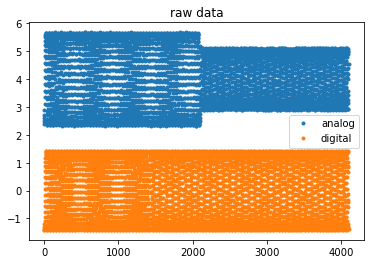

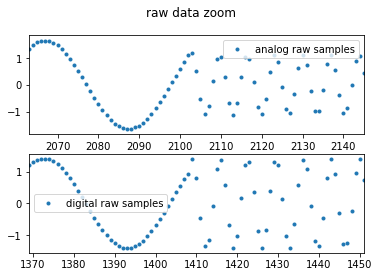

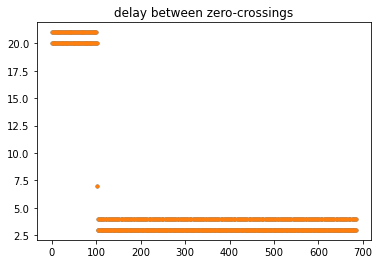

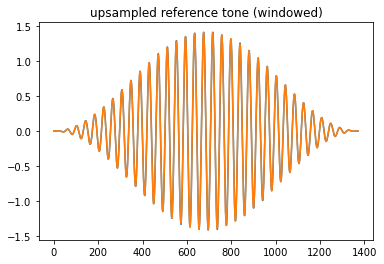

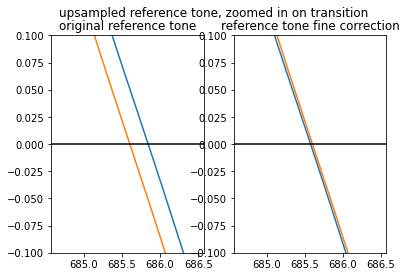

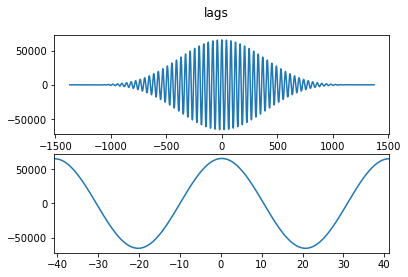

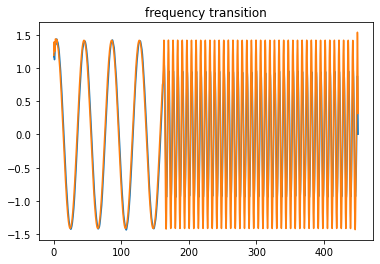

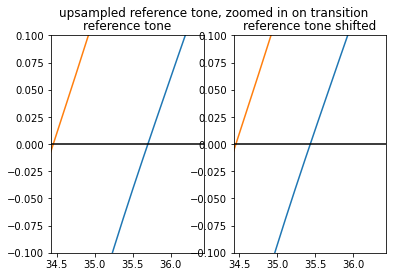

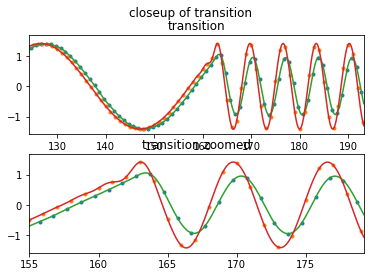

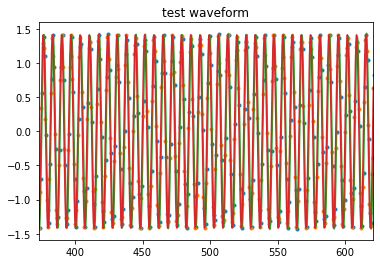

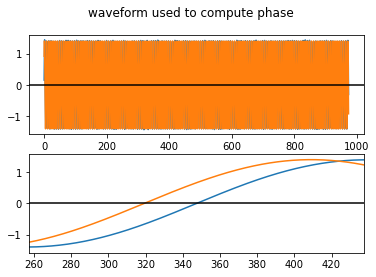

In [21]:
ol.dbg = True
ol.plot = True
OSR = 128
tones = np.floor((np.array([100e6, 600e6])/ol.f_samp)*2**ol.phase_bits)*ol.f_samp/2**ol.phase_bits
print(f'tones = {tones}')
vga_atten_dB = 18
dac_atten_dB = 0
t1 = time.time()
phi = ol.measure_phase('afe', tones, OSR, vga_atten_dB, dac_atten_dB)
ampl = np.std(scipy.signal.resample_poly(np.array(ol.dma_buffers[0][4096:8192,0],dtype=np.float32),32,1,axis=0))
t2 = time.time()
print(f'phi = {phi} = {phi*180/np.pi} deg')
print(f'ampl = {ampl}')
print(f'dt = {t2-t1}')

In [ ]:
ol.dbg = False
ol.plot = False
# phase estimation parameters
OSR = 128
# sweep parameters
N_freqs = 60
N_avg = 30
vga_atten_dB = 18 # best settings for SFDR
dac_atten_dB = 12
freqs = np.floor((np.logspace(np.log10(30e6), np.log10(1900e6), N_freqs)/ol.f_samp)*2**ol.phase_bits)*ol.f_samp/2**ol.phase_bits
ref_tones = np.where(freqs >= 500e6, 200e6, np.where(freqs >= 200e6, 100e6, 20e6))
raw_phases = np.zeros((N_freqs,N_avg,2))
raw_mags = np.zeros((N_freqs,N_avg,2))
print(f'starting sweep, estimated time is ~{N_freqs*N_avg}s ({(N_freqs*N_avg)//60}:{(N_freqs*N_avg)%60})')
t1 = time.time()
for i,freq in enumerate(freqs):
    ref_tone = 200e6 if freq >= 500e6 else (100e6 if freq >= 200e6 else 20e6)
    tones = np.array([20e6, freq])
    print(f'starting frequency {round(freq/1e6,3)}MHz ({round(i/len(freqs)*100)}% done)')
    for j in range(N_avg):
        for k,src in enumerate(['afe','balun']):
            success = False
            while not success:
                try:
                    raw_phases[i,j,k] = ol.measure_phase(src,tones,OSR,vga_atten_dB,dac_atten_dB)
                    success = True
                except ValueError:
                    success = False
            raw_mags[i,j,k] = np.std(scipy.signal.resample_poly(np.array(ol.dma_buffers[0][4096:8192,0],dtype=np.float32),32,1,axis=0))
t2 = time.time()
scipy.io.savemat('data/afe_vs_balun_freq_response_fixed.mat', {'vga_atten_dB': vga_atten_dB, 'dac_atten_dB': dac_atten_dB, 'freqs_hz': freqs, 'ref_tones_hz': ref_tones, 'raw_phases_rad': raw_phases, 'raw_mags_au': raw_mags})
print(f'took {round((t2-t1))}s to perform {N_freqs*N_avg*2} measurements ({N_freqs*N_avg*2/round(t2-t1)} measurements/s)')

starting sweep, estimated time is ~1800s (30:0)
starting frequency 30.0MHz (0% done)
starting frequency 32.185MHz (2% done)
starting frequency 34.53MHz (3% done)
starting frequency 37.045MHz (5% done)
starting frequency 39.743MHz (7% done)
starting frequency 42.638MHz (8% done)
starting frequency 45.744MHz (10% done)
starting frequency 49.076MHz (12% done)
starting frequency 52.651MHz (13% done)
starting frequency 56.487MHz (15% done)
starting frequency 60.601MHz (17% done)
starting frequency 65.016MHz (18% done)
starting frequency 69.752MHz (20% done)
starting frequency 74.833MHz (22% done)
starting frequency 80.283MHz (23% done)
starting frequency 86.132MHz (25% done)
starting frequency 92.406MHz (27% done)
starting frequency 99.137MHz (28% done)
starting frequency 106.358MHz (30% done)
starting frequency 114.106MHz (32% done)
starting frequency 122.417MHz (33% done)
starting frequency 131.335MHz (35% done)
starting frequency 140.902MHz (37% done)
starting frequency 151.165MHz (38% d

Text(0.5, 0, 'freq [Hz]')

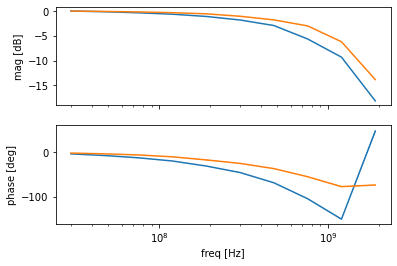

In [13]:
# full loopback configuration:
# 0: RFSoC DAC -> AFE DAC buffer -> AFE ADC buffer -> RFSoC ADC ('adc')
# 1: RFSoC DAC -> RFSoC ADC ('balun')
# "adaptive" reference tone
fig, ax = plt.subplots(2,1,sharex=True)
mags_norm = raw_mags/np.max(raw_mags,axis=0)
mags_mean = np.median(mags_norm,axis=1)
mags_std = np.std(mags_norm,axis=1)
mags_dB = 20*np.log10(mags_mean)
mags_dB_low = 20*np.log10(mags_mean-mags_std)
mags_dB_high = 20*np.log10(mags_mean+mags_std)
ax[0].plot(freqs,mags_dB)
ax[0].fill_between(freqs,mags_dB_low[:,0],mags_dB_high[:,0],alpha=0.9)
ax[0].fill_between(freqs,mags_dB_low[:,1],mags_dB_high[:,1],alpha=0.9)
ax[0].set_ylabel('mag [dB]')
wrapped_phases = raw_phases*180/np.pi
wrapped_phases[(wrapped_phases > 180)] -= 360
phase_mean = -np.median(wrapped_phases,axis=1)
phase_std = -np.std(wrapped_phases,axis=1)
ax[1].plot(freqs,phase_mean)
ax[1].fill_between(freqs,phase_mean[:,0]-phase_std[:,0],phase_mean[:,0]+phase_std[:,0],alpha=0.9)
ax[1].fill_between(freqs,phase_mean[:,1]-phase_std[:,1],phase_mean[:,1]+phase_std[:,1],alpha=0.9)
ax[1].set_ylabel('phase [deg]')
plt.xscale('log')
plt.xlabel('freq [Hz]')
#plt.xlim([30e6, 1900e6])
#plt.ylim([-50, 5])

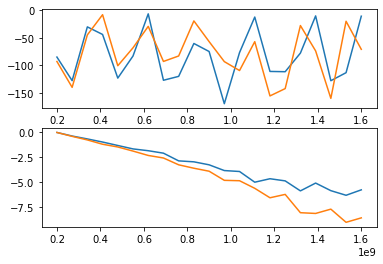

In [27]:
# partial loopback:
# RFSoC DAC -> AFE ADC buffer -> RFSoC ADC ('adc')
# RFSoC DAC -> AFE DAC buffer -> RFSoC ADC ('balun')
fig, ax = plt.subplots(2,1)
ax[0].plot(freqs,-np.median(raw_phases,axis=1)*180/np.pi) # with 128MHz reference
mags_dB = 20*np.log10(raw_mags)
ax[1].plot(freqs,np.median(mags_dB,axis=1)-np.max(np.median(mags_dB,axis=1),axis=0)) # with 128MHz reference

setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 262144 (6.400e+07Hz)
setting pinc to 3276800 (8.000e+08Hz)


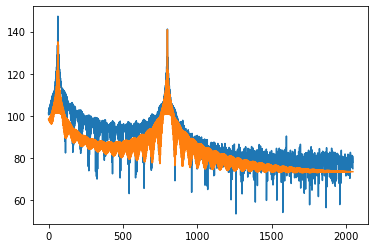

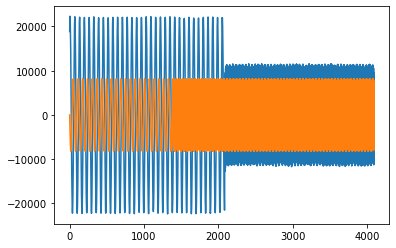

In [3]:
# send something
ol.set_vga_atten_dB(18)
ol.set_dac_atten_dB(12)
ol.set_adc_source('afe')
ol.set_sample_buffer_trigger_source('manual')
ol.set_freq_hz(64e6)
ol.set_sample_buffer_trigger_source('dds_auto')
ol.set_freq_hz(800e6)
ol.manual_trigger()
ol.dma(0)
time.sleep(0.1)
fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0][:4096,:], axis=0))+1)[1:-1,:]
plt.figure()
plt.plot(fft)
plt.figure()
plt.plot(ol.dma_buffers[0][:4096,:])

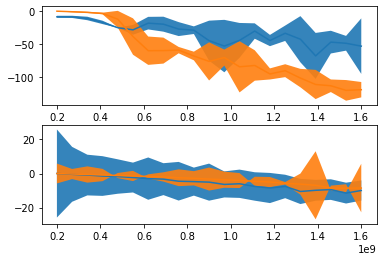

In [24]:
# full loopback configuration:
# 0: RFSoC DAC -> AFE DAC buffer -> AFE ADC buffer -> RFSoC ADC ('adc')
# 1: RFSoC DAC -> RFSoC ADC ('balun')
fig, ax = plt.subplots(2,1)
phase_mean = -np.mean(raw_phases,axis=1)*180/np.pi
phase_std = -np.std(raw_phases,axis=1)*180/np.pi
ax[0].plot(freqs,phase_mean) # with 256MHz reference
ax[0].fill_between(freqs,phase_mean[:,0]-phase_std[:,0],phase_mean[:,0]+phase_std[:,0],alpha=0.9) # with 256MHz reference
ax[0].fill_between(freqs,phase_mean[:,1]-phase_std[:,1],phase_mean[:,1]+phase_std[:,1],alpha=0.9) # with 256MHz reference
mags_dB = 20*np.log10(raw_mags)
mag_mean = np.mean(mags_dB,axis=1)
mag_mean -= np.max(mag_mean,axis=0)
mag_std = 20*np.log10(np.std(raw_mags,axis=1))
ax[1].plot(freqs,mag_mean) # with 256MHz reference
ax[1].fill_between(freqs,mag_mean[:,0]-mag_std[:,0],mag_mean[:,0]+mag_std[:,0],alpha=0.9) # with 256MHz reference
ax[1].fill_between(freqs,mag_mean[:,1]-mag_std[:,1],mag_mean[:,1]+mag_std[:,1],alpha=0.9) # with 256MHz reference

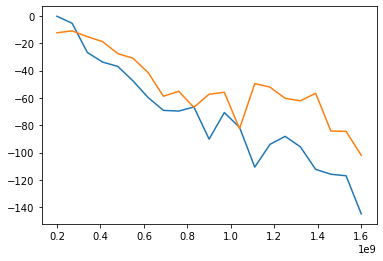

In [5]:
plt.plot(freqs,-np.mean(raw_phases,axis=1)*180/np.pi) # with 128MHz reference

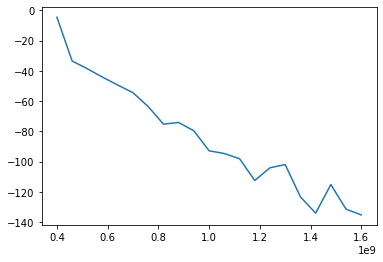

In [7]:
plt.plot(freqs,-np.median(raw_phases,axis=1)*180/np.pi) # with 256MHz reference

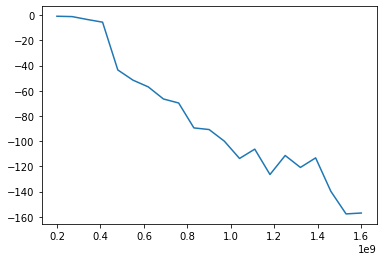

In [5]:
plt.plot(freqs,-np.median(raw_phases,axis=1)*180/np.pi) # with 128MHz reference

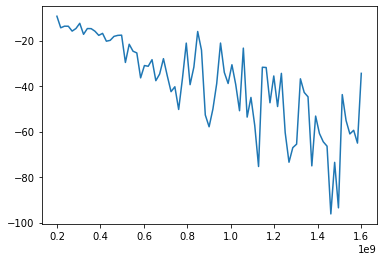

In [7]:
plt.plot(freqs,-np.median(raw_phases,axis=1)*180/np.pi) # with 64MHz reference

[12.65583101 12.68128587]


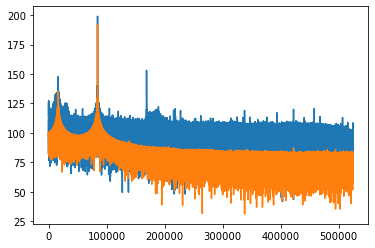

In [41]:
def sfdr_dBc(buffer, buffer_len=65536):
    fft = abs(np.fft.rfft(buffer, axis=0))[1:-1,:]
    fft.sort(axis=0)
    return 20*np.log10(fft[-1,:]/fft[-2,:])
print(sfdr_dBc(ol.dma_buffers[0]))

fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0], axis=0)))[1:-1,:]
plt.plot(fft)

setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 81920 (2.000e+07Hz)
transferred 4.0MiB in 106us (19.852GS/s)
setting pinc to 81928 (2.000e+07Hz)
transferred 4.0MiB in 100us (20.952GS/s)
setting pinc to 81936 (2.000e+07Hz)
transferred 4.0MiB in 100us (21.008GS/s)
setting pinc to 81944 (2.001e+07Hz)
transferred 4.0MiB in 99us (21.102GS/s)
setting pinc to 81952 (2.001e+07Hz)
transferred 4.0MiB in 98us (21.499GS/s)
setting pinc to 81960 (2.001e+07Hz)
transferred 4.0MiB in 99us (21.102GS/s)
setting pinc to 81969 (2.001e+07Hz)
transferred 4.0MiB in 100us (20.953GS/s)
setting pinc to 81977 (2.001e+07Hz)
transferred 4.0MiB in 100us (20.888GS/s)
setting pinc to 81985 (2.002e+07Hz)
transferred 4.0MiB in 98us (21.324GS/s)
setting pinc to 81993 (2.002e+07Hz)
transferred 4.0MiB in 101us (20.758GS/s)
setting pinc to 82001 (2.002e+07Hz)
transferred 4.0MiB in 99us (21.24GS/s)
setting pinc to 82010 (2.002e+07Hz)
transferred 4.0MiB in 98us (21.302GS/s)
setting p

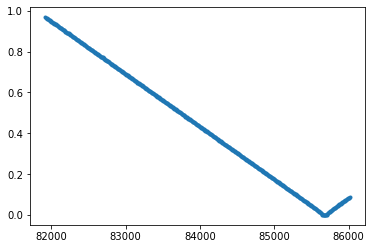

In [138]:
# calculate phase vs frequency
ol.plot = False

ol.set_vga_atten_dB(18)
ol.set_dac_atten_dB(12)
freqs = np.linspace(20e6, 21e6, 501)
phase = np.zeros(freqs.shape)
for i,freq in enumerate(freqs):
    ol.set_freq_hz(freq)
    ol.capture_data(ol.dma_buffers[0])
    N_samp = 16384
    raw = ol.dma_buffers[0][:N_samp,:]
    raw = (raw - np.mean(raw, axis=0))/np.std(raw, axis=0)
    c = np.cov(np.transpose(raw))
    phase[i] = np.arccos(np.clip(c[0,1],-1,1))
# calculate phase_offset_200MHz and phase_inc_per_hz
phase_incs = ((freqs/ol.f_samp)*(2**ol.phase_bits)).astype(np.uint32)
A = np.vstack([phase_incs, np.ones(len(phase_incs))]).T
phase_inc_per_pinc_20MHz, phase_offset_pinc_20MHz = np.linalg.lstsq(A, phase, rcond=None)[0]
phase_offset_pinc_20MHz += phase_inc_per_pinc_20MHz*int((20e6/ol.f_samp)*(2**ol.phase_bits))
print(phase_inc_per_pinc_20MHz*2**24, phase_offset_pinc_20MHz)
plt.plot(phase_incs, phase, '.')

In [206]:
print(phase_inc_per_pinc_20MHz*2**24, phase_offset_pinc_20MHz)

-4157.475619017378 0.9547335876903951


setting pinc to 831488 (2.030e+08Hz)
setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
transferred 4.0MiB in 113us (18.622GS/s)


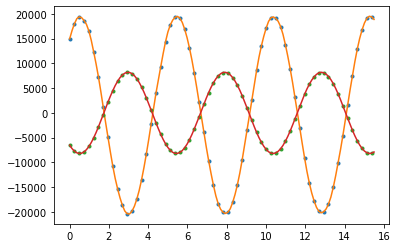

In [47]:
ol.plot = True
ol.set_freq_hz(203e6)
ol.set_vga_atten_dB(18)
ol.set_dac_atten_dB(12)
ol.capture_data(ol.dma_buffers[0], N_samp=64, OSR=2)

setting pinc to 819200 (2.000e+08Hz)
setting vga attenuation to 0dB
b'read attenuation back: 0dB\r\n'
b'Invalid character; please input attenuation in dB (as a 2-digit decimal) and press ENTER\r\n'
b'setting attenuation to 12dB\r\n'
b'read attenuation back: 0dB\r\n'
b'0\r\n'
b'setting attenuation to 0dB\r\n'
setting cos_scale to 0 (0dB attenuation)
transferred 4.0MiB in 118us (17.718GS/s)


NameError: name 'sfdr_dBc' is not defined

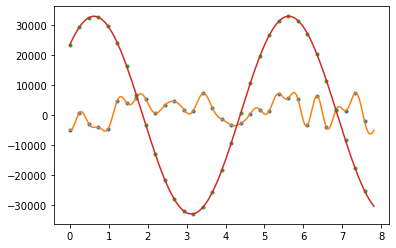

In [13]:
ol.set_freq_hz(200e6)
sfdr = np.zeros((33,11))
vga_atten_settings = np.linspace(0,32,33)
dac_atten_settings = np.linspace(0,60,11)
for v,vga_atten in enumerate(vga_atten_settings):
    ol.set_vga_atten_dB(vga_atten)
    for d,dac_atten in enumerate(dac_atten_settings):
        ol.set_dac_atten_dB(dac_atten)
        ol.capture_data(ol.dma_buffers[0], N_samp=32, OSR=1024)
        sfdr[v,d] = sfdr_dBc(ol.dma_buffers[0])
        print(f'for vga_atten = {vga_atten}, dac_atten = {dac_atten}, got SFDR = {sfdr[v,d]}')

In [62]:
scipy.io.savemat('data/afe_loopback_dac_sfdr_200MHz.mat', {'vga_atten': vga_atten_settings, 'dac_atten': dac_atten_settings, 'sfdr': sfdr, 'freq': 1.4e9})

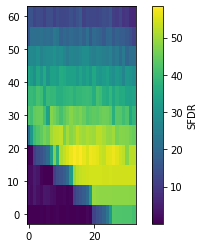

In [64]:
#plt.imshow(sfdr, interpolation=None, origin='lower', extent=[-3, 63, 0, 32])
v,d = np.meshgrid(vga_atten_settings, dac_atten_settings)
plt.pcolor(v, d, np.transpose(sfdr))
cb=plt.colorbar()
cb.set_label('SFDR')
plt.gca().set_aspect('equal')

In [9]:
fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0])))-20*np.log10(ol.dma_frame_size*(2**16))

/tmp/ipykernel_14742/727962273.py:1: RuntimeWarning: divide by zero encountered in log10
  fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0])))-20*np.log10(ol.dma_frame_size*(2**16))


[-30.32266976967722, -84.45834857261463, -92.64246328227352, -93.48622157603435, -93.65850278301221]
54.135678802937406


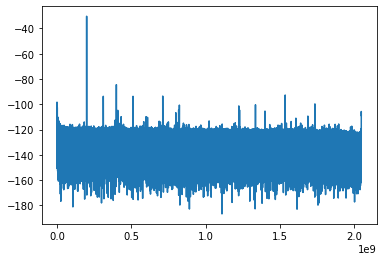

In [4]:
fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0])))-20*np.log10(ol.dma_frame_size*(2**16))
fvec = np.linspace(0,ol.f_samp/2,ol.dma_frame_size//2+1,endpoint=True)
plt.plot(fvec[1:-1],fft[1:-1])
#plt.xlim([2.048e9-2e6, 2.048e9+2e6])
peaks = sorted(fft[1:-1], reverse=True)[:5]
print(peaks)
print(peaks[0] - peaks[1])

In [3]:
vga_setting = 0
for scale in [0, 6, 12, 30, 60]:
    ol.do_freq_sweep(f"data/afe_loopback_dac_{scale}dB_vga_{vga_setting}dB.mat", scale, np.logspace(4, 9.25, 200))

setting cos_scale to 0 (0dB attenuation)
setting pinc to 40 (1.000e+04Hz)
transferred 4.0MiB in 110us (19.086GS/s)
setting pinc to 43 (1.063e+04Hz)
transferred 4.0MiB in 90us (23.265GS/s)
setting pinc to 46 (1.129e+04Hz)
transferred 4.0MiB in 82us (25.591GS/s)
setting pinc to 49 (1.200e+04Hz)
transferred 4.0MiB in 81us (25.749GS/s)
setting pinc to 52 (1.275e+04Hz)
transferred 4.0MiB in 81us (25.818GS/s)
setting pinc to 55 (1.355e+04Hz)
transferred 4.0MiB in 82us (25.596GS/s)
setting pinc to 58 (1.440e+04Hz)
transferred 4.0MiB in 81us (25.833GS/s)
setting pinc to 62 (1.530e+04Hz)
transferred 4.0MiB in 82us (25.73GS/s)
setting pinc to 66 (1.626e+04Hz)
transferred 4.0MiB in 81us (25.884GS/s)
setting pinc to 70 (1.728e+04Hz)
transferred 4.0MiB in 82us (25.61GS/s)
setting pinc to 75 (1.836e+04Hz)
transferred 4.0MiB in 84us (24.978GS/s)
setting pinc to 79 (1.951e+04Hz)
transferred 4.0MiB in 82us (25.492GS/s)
setting pinc to 84 (2.073e+04Hz)
transferred 4.0MiB in 82us (25.612GS/s)
setting pin